# Análisis de ventas de videojuegos (Ice)

## Objetivo

El objetivo de este proyecto es identificar patrones que determinan el éxito comercial de los videojuegos, utilizando datos históricos de ventas, plataformas, géneros y reseñas. 

El análisis se enfoca en apoyar la planeación de campañas publicitarias para el año 2017, considerando que los datos disponibles llegan hasta 2016.

## Preguntas clave
- ¿Qué plataformas y géneros generan mayores ventas en el periodo reciente?
- ¿Cómo varían las preferencias de los usuarios por región (NA, UE, JP)?
- ¿Qué relación existe entre las reseñas (críticos y usuarios) y las ventas?
- ¿Existen diferencias estadísticamente significativas en las calificaciones promedio entre plataformas y géneros?

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

pd.set_option("display.max_columns", None)

## 1. Carga de datos
En esta sección se carga el dataset original y se realiza una revisión general de su estructura, columnas y tipos de datos, con el fin de entender la información disponible antes de iniciar la limpieza y el análisis.

In [4]:
df = pd.read_csv("data/games.csv")
df.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [5]:
df.info()
df.describe(include="all")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
count,16713,16715,16446.000000,16713,16715.000000,16715.000000,16715.000000,16715.000000,8137.000000,10014,9949
unique,11559,31,NaN,12,NaN,NaN,NaN,NaN,NaN,96,8
top,Need for Speed: Most Wanted,PS2,NaN,Action,NaN,NaN,NaN,NaN,NaN,tbd,E
freq,12,2161,NaN,3369,NaN,NaN,NaN,NaN,NaN,2424,3990
mean,NaN,NaN,2006.484616,NaN,0.263377,0.145060,0.077617,0.047342,68.967679,NaN,NaN
std,NaN,NaN,5.877050,NaN,0.813604,0.503339,0.308853,0.186731,13.938165,NaN,NaN
min,NaN,NaN,1980.000000,NaN,0.000000,0.000000,0.000000,0.000000,13.000000,NaN,NaN
25%,NaN,NaN,2003.000000,NaN,0.000000,0.000000,0.000000,0.000000,60.000000,NaN,NaN
50%,NaN,NaN,2007.000000,NaN,0.080000,0.020000,0.000000,0.010000,71.000000,NaN,NaN
75%,NaN,NaN,2010.000000,NaN,0.240000,0.110000,0.040000,0.030000,79.000000,NaN,NaN


## 2. Preparación de datos
En esta sección se prepara el dataset para el análisis:
- Se estandarizan los nombres de las columnas.
- Se convierten los tipos de datos a formatos adecuados.
- Se manejan valores ausentes, incluyendo el valor 'tbd' en la columna `user_score`.
- Se crea la variable `total_sales`, que representa las ventas globales y será la métrica principal del análisis.

In [7]:
df.columns

Index(['Name', 'Platform', 'Year_of_Release', 'Genre', 'NA_sales', 'EU_sales',
       'JP_sales', 'Other_sales', 'Critic_Score', 'User_Score', 'Rating'],
      dtype='object')

In [8]:
df.columns = df.columns.str.lower()
df.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

In [9]:
expected_cols = {
    'name','platform','year_of_release','genre',
    'na_sales','eu_sales','jp_sales','other_sales',
    'critic_score','user_score','rating'
}
expected_cols.issubset(set(df.columns))

True

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [11]:
df['user_score'].value_counts(dropna=False).head(10)

user_score
NaN    6701
tbd    2424
7.8     324
8       290
8.2     282
8.3     254
8.5     253
7.5     251
7.9     249
8.1     244
Name: count, dtype: int64

La columna `user_score` contiene el valor especial 'tbd', que no representa una calificación numérica. Estos valores se convierten a `NaN` para permitir el análisis estadístico.

In [13]:
df['user_score'] = df['user_score'].replace('tbd', np.nan)
df['user_score'] = pd.to_numeric(df['user_score'], errors='coerce')

In [14]:
df['user_score'].dtype

dtype('float64')

In [15]:
(df['user_score'] == 'tbd').sum()

0

In [16]:
df['year_of_release'].dtype

dtype('float64')

In [17]:
df['year_of_release'] = pd.to_numeric(df['year_of_release'], errors='coerce').astype('Int64')

In [18]:
df['year_of_release'].dtype

Int64Dtype()

In [19]:
df['year_of_release'].isna().sum()

269

In [20]:
df['year_of_release'].min(), df['year_of_release'].max()

(1980, 2016)

In [21]:
df[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].dtypes

na_sales       float64
eu_sales       float64
jp_sales       float64
other_sales    float64
dtype: object

In [22]:
sales_cols = ['na_sales', 'eu_sales', 'jp_sales', 'other_sales']

for col in sales_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

In [23]:
df['total_sales'] = df[sales_cols].sum(axis=1)

La variable `total_sales` se utiliza como métrica central para comparar el desempeño comercial de los videojuegos.

In [25]:
df[['na_sales', 'eu_sales', 'jp_sales', 'other_sales', 'total_sales']].head()

,na_sales,eu_sales,jp_sales,other_sales,total_sales
0,41.36,28.96,3.77,8.45,82.54
1,29.08,3.58,6.81,0.77,40.24
2,15.68,12.76,3.79,3.29,35.52
3,15.61,10.93,3.28,2.95,32.77
4,11.27,8.89,10.22,1.00,31.38


In [26]:
(df['total_sales'] < 0).sum()

0

In [27]:
df['total_sales'].describe()

count    16715.000000
mean         0.533396
std          1.548261
min          0.000000
25%          0.060000
50%          0.170000
75%          0.470000
max         82.540000
Name: total_sales, dtype: float64

## 3. Análisis exploratorio
El análisis exploratorio permite identificar tendencias generales en los datos, como la evolución de lanzamientos, el desempeño de plataformas y géneros, y la relación entre reseñas y ventas. 

A partir de este análisis se define el periodo más relevante para planear decisiones de marketing en 2017.

In [29]:
games_per_year = df.groupby('year_of_release')['name'].count()
games_per_year.head()

year_of_release
1980     9
1981    46
1982    36
1983    17
1984    14
Name: name, dtype: int64

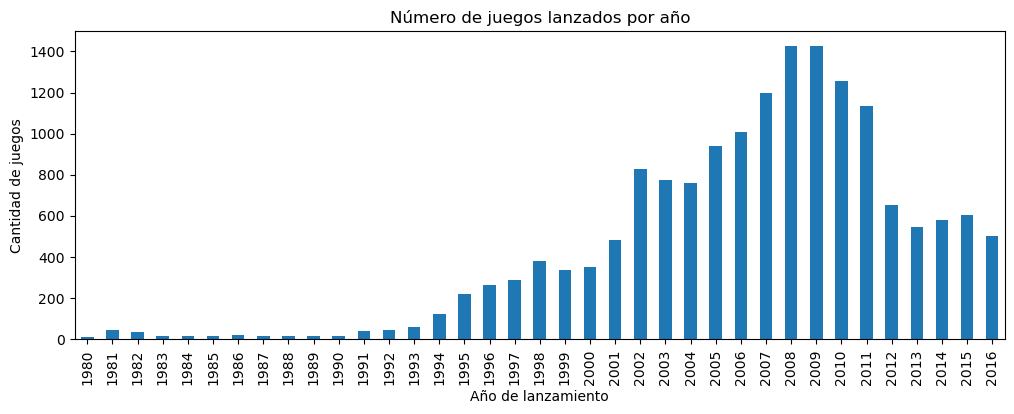

In [30]:
plt.figure(figsize=(12, 4))
games_per_year.plot(kind='bar')
plt.title('Número de juegos lanzados por año')
plt.xlabel('Año de lanzamiento')
plt.ylabel('Cantidad de juegos')
plt.show()

**Hallazgos:**
- A partir de ~2001 el número de lanzamientos crece y los datos son más representativos.
- 2016 parece incompleto frente a años anteriores.

**Implicación para 2017:**
- Para decisiones de 2017 conviene priorizar un periodo reciente donde las plataformas actuales estén activas.

In [32]:
games_per_year.sort_values(ascending=False).head(5)

year_of_release
2008    1427
2009    1426
2010    1255
2007    1197
2011    1136
Name: name, dtype: int64

In [33]:
platform_sales = (
    df
    .groupby('platform')['total_sales']
    .sum()
    .sort_values(ascending=False)
)

platform_sales.head(10)

platform
PS2     1255.77
X360     971.42
PS3      939.65
Wii      907.51
DS       806.12
PS       730.86
GBA      317.85
PS4      314.14
PSP      294.05
PC       259.52
Name: total_sales, dtype: float64

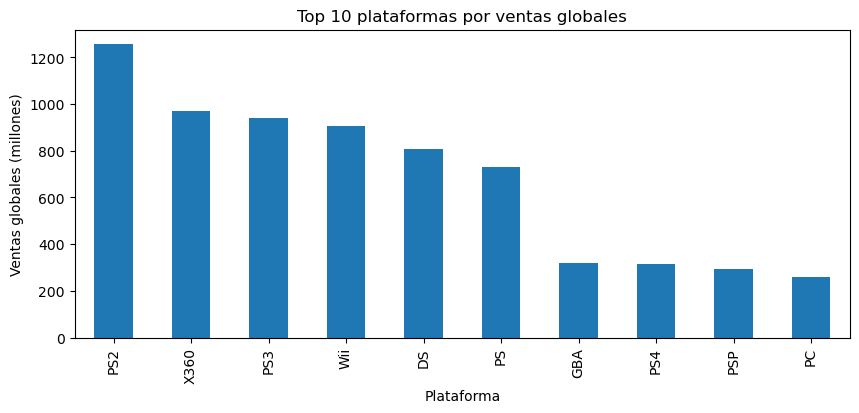

In [34]:
plt.figure(figsize=(10, 4))
platform_sales.head(10).plot(kind='bar')
plt.title('Top 10 plataformas por ventas globales')
plt.xlabel('Plataforma')
plt.ylabel('Ventas globales (millones)')
plt.show()

**Hallazgos:**
- PS4 presenta la mediana de ventas más alta en el periodo 2013–2016.
- PS4 y PS3 muestran alta variabilidad, indicando la presencia de títulos con ventas excepcionalmente altas.
- Se observan outliers importantes en todas las plataformas.

**Implicación para 2017:**
- PS4 destaca como la plataforma más atractiva para campañas publicitarias.

In [36]:
platform_sales.describe()

count      31.000000
mean      287.603548
std       348.160256
min         0.030000
25%        23.360000
50%       200.040000
75%       304.095000
max      1255.770000
Name: total_sales, dtype: float64

In [37]:
sales_year_platform = df.pivot_table(
    index='year_of_release',
    columns='platform',
    values='total_sales',
    aggfunc='sum'
)

sales_year_platform.tail()

platform,2600,3DO,3DS,DC,DS,GB,GBA,GC,GEN,GG,N64,NES,NG,PC,PCFX,PS,PS2,PS3,PS4,PSP,PSV,SAT,SCD,SNES,TG16,WS,Wii,WiiU,X360,XB,XOne
year_of_release,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2012,NaN,NaN,51.36,NaN,11.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.22,NaN,NaN,NaN,107.36,NaN,7.69,16.19,NaN,NaN,NaN,NaN,NaN,21.71,17.56,99.74,NaN,NaN
2013,NaN,NaN,56.57,NaN,1.54,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.38,NaN,NaN,NaN,113.25,25.99,3.14,10.59,NaN,NaN,NaN,NaN,NaN,8.59,21.65,88.58,NaN,18.96
2014,NaN,NaN,43.76,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.28,NaN,NaN,NaN,47.76,100.00,0.24,11.90,NaN,NaN,NaN,NaN,NaN,3.75,22.03,34.74,NaN,54.07
2015,NaN,NaN,27.78,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.52,NaN,NaN,NaN,16.82,118.90,0.12,6.25,NaN,NaN,NaN,NaN,NaN,1.14,16.35,11.96,NaN,60.14
2016,NaN,NaN,15.14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.25,NaN,NaN,NaN,3.60,69.25,NaN,4.25,NaN,NaN,NaN,NaN,NaN,0.18,4.60,1.52,NaN,26.15


In [38]:
top_platforms = ['PS2', 'X360', 'PS3', 'Wii', 'DS']

<Figure size 1200x500 with 0 Axes>

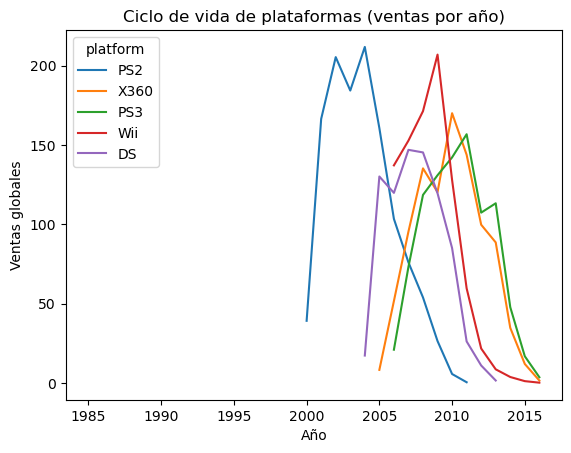

In [39]:
plt.figure(figsize=(12, 5))
sales_year_platform[top_platforms].plot()
plt.title('Ciclo de vida de plataformas (ventas por año)')
plt.xlabel('Año')
plt.ylabel('Ventas globales')
plt.show()

In [40]:
sales_year_platform.loc[2013:2016].sum().sort_values(ascending=False)

platform
PS4     314.14
PS3     181.43
XOne    159.32
3DS     143.25
X360    136.80
WiiU     64.63
PC       39.43
PSV      32.99
Wii      13.66
PSP       3.50
DS        1.54
XB        0.00
TG16      0.00
SNES      0.00
SCD       0.00
SAT       0.00
WS        0.00
2600      0.00
PS2       0.00
3DO       0.00
PCFX      0.00
NG        0.00
NES       0.00
N64       0.00
GG        0.00
GEN       0.00
GC        0.00
GBA       0.00
GB        0.00
DC        0.00
PS        0.00
dtype: float64

In [41]:
df_recent = df[df['year_of_release'] >= 2013].copy()
df_recent.shape

(2233, 12)

In [42]:
df_recent['year_of_release'].value_counts().sort_index()

year_of_release
2013    544
2014    581
2015    606
2016    502
Name: count, dtype: Int64

In [43]:
df_recent['total_sales'].sum()

1090.69

In [44]:
recent_platform_sales = (
    df_recent
    .groupby('platform')['total_sales']
    .sum()
    .sort_values(ascending=False)
)

recent_platform_sales

platform
PS4     314.14
PS3     181.43
XOne    159.32
3DS     143.25
X360    136.80
WiiU     64.63
PC       39.43
PSV      32.99
Wii      13.66
PSP       3.50
DS        1.54
Name: total_sales, dtype: float64

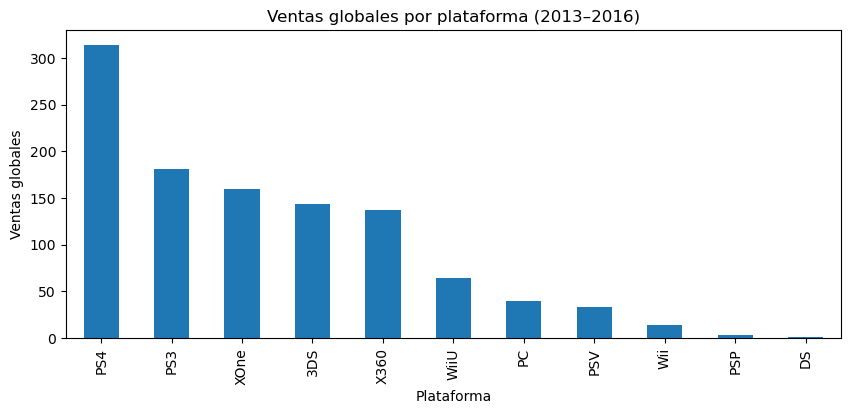

In [45]:
plt.figure(figsize=(10, 4))
recent_platform_sales.plot(kind='bar')
plt.title('Ventas globales por plataforma (2013–2016)')
plt.xlabel('Plataforma')
plt.ylabel('Ventas globales')
plt.show()

**Hallazgos:**
- PS4 lidera ventas en el periodo reciente; PS3 y XOne también destacan.
- Algunas plataformas muestran declive (ej. Wii), lo que sugiere pérdida de relevancia.

**Implicación para 2017:**
- PS4 y XOne son candidatas fuertes para enfocar campañas en 2017.

In [47]:
platform_trend = df_recent.pivot_table(
    index='year_of_release',
    columns='platform',
    values='total_sales',
    aggfunc='sum'
)

platform_trend

platform,3DS,DS,PC,PS3,PS4,PSP,PSV,Wii,WiiU,X360,XOne
year_of_release,,,,,,,,,,,
2013,56.57,1.54,12.38,113.25,25.99,3.14,10.59,8.59,21.65,88.58,18.96
2014,43.76,NaN,13.28,47.76,100.00,0.24,11.90,3.75,22.03,34.74,54.07
2015,27.78,NaN,8.52,16.82,118.90,0.12,6.25,1.14,16.35,11.96,60.14
2016,15.14,NaN,5.25,3.60,69.25,NaN,4.25,0.18,4.60,1.52,26.15


In [48]:
top_recent_platforms = ['PS4', 'PS3', 'XOne', 'Wii', '3DS']

<Figure size 1200x500 with 0 Axes>

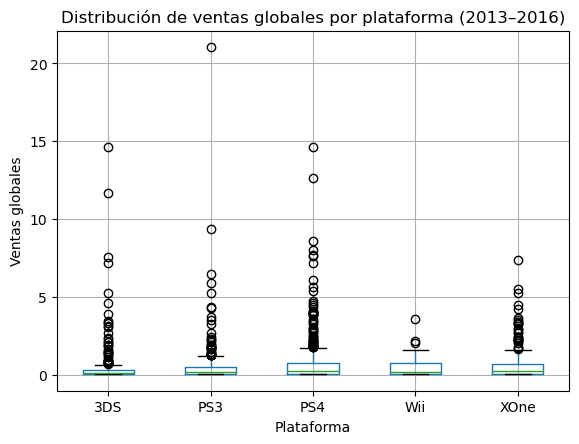

In [49]:
plt.figure(figsize=(12, 5))
df_recent[df_recent['platform'].isin(top_recent_platforms)].boxplot(
    column='total_sales',
    by='platform'
)
plt.title('Distribución de ventas globales por plataforma (2013–2016)')
plt.suptitle('')
plt.xlabel('Plataforma')
plt.ylabel('Ventas globales')
plt.show()

### Distribución de ventas por plataforma

El boxplot muestra diferencias claras entre las plataformas analizadas.
PS4 presenta la mediana de ventas más alta, lo que indica un mejor desempeño promedio de sus juegos en el periodo 2013–2016.
Además, PS4 y PS3 muestran una alta variabilidad en las ventas, lo que sugiere que, aunque muchos juegos venden poco, existen títulos con ventas excepcionalmente altas.


In [51]:
ps4_data = df_recent[df_recent['platform'] == 'PS4'][['critic_score', 'user_score', 'total_sales']]
ps4_data = ps4_data.dropna()
ps4_data.head()

,critic_score,user_score,total_sales
42,97.0,8.3,12.62
77,82.0,4.3,8.58
92,83.0,5.7,7.66
94,85.0,5.0,7.60
105,87.0,6.5,7.17


In [52]:
ps4_data.describe()

,critic_score,user_score,total_sales
count,249.000000,249.000000,249.000000
mean,72.132530,6.749799,0.981004
std,12.550965,1.455693,1.646217
min,19.000000,1.500000,0.010000
25%,66.000000,6.100000,0.080000
50%,74.000000,7.000000,0.300000
75%,80.000000,7.800000,1.100000
max,97.000000,9.200000,12.620000


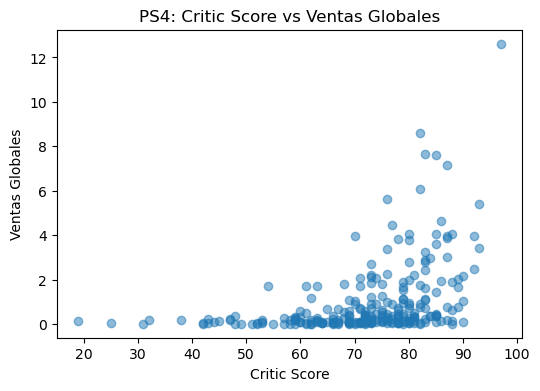

In [53]:
plt.figure(figsize=(6, 4))
plt.scatter(ps4_data['critic_score'], ps4_data['total_sales'], alpha=0.5)
plt.title('PS4: Critic Score vs Ventas Globales')
plt.xlabel('Critic Score')
plt.ylabel('Ventas Globales')
plt.show()

In [54]:
ps4_data['critic_score'].corr(ps4_data['total_sales'])

0.40589480145836687

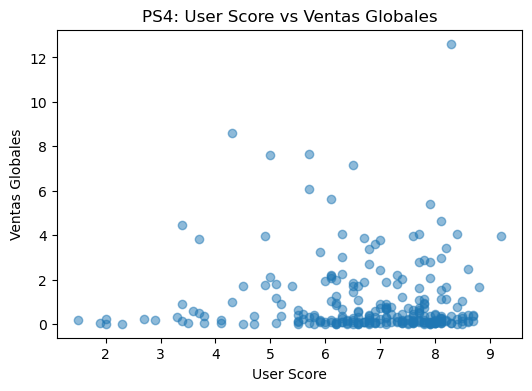

In [55]:
plt.figure(figsize=(6, 4))
plt.scatter(ps4_data['user_score'], ps4_data['total_sales'], alpha=0.5)
plt.title('PS4: User Score vs Ventas Globales')
plt.xlabel('User Score')
plt.ylabel('Ventas Globales')
plt.show()

In [56]:
ps4_data['user_score'].corr(ps4_data['total_sales'])

-0.03362497596528878

**Hallazgos:**
- En PS4, critic_score tiene correlación moderada con ventas (r≈0.40589480145836687).
- user_score casi no se relaciona con ventas (r≈-0.03362497596528878).

**Implicación para 2017:**
- Las reseñas de críticos pueden usarse como señal complementaria; las de usuarios no parecen predecir ventas de forma útil.

### Influencia de las reseñas en las ventas (PS4)

El análisis muestra una correlación positiva moderada entre las calificaciones de los críticos y las ventas globales (r ≈ 0.41), lo que sugiere que una mejor recepción por parte de expertos puede contribuir a mayores ventas.
En contraste, las calificaciones de los usuarios no muestran una relación significativa con las ventas, lo que indica que su impacto en el desempeño comercial es limitado.

Estos resultados sugieren que, si bien las reseñas influyen en las ventas, no son el único factor determinante del éxito de un videojuego.

In [59]:
multi_platform_games = (
    df_recent
    .groupby('name')['platform']
    .nunique()
)

multi_platform_games = multi_platform_games[multi_platform_games > 1].index
len(multi_platform_games)

473

In [60]:
df_multi = df_recent[df_recent['name'].isin(multi_platform_games)]
df_multi.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
16,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97.0,8.2,M,21.05
23,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97.0,8.1,M,16.27
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,NaN,14.63
42,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97.0,8.3,M,12.62
60,Call of Duty: Ghosts,X360,2013,Shooter,6.73,2.56,0.04,0.91,73.0,2.6,M,10.24


In [61]:
top_game = (
    df_multi
    .groupby('name')['total_sales']
    .sum()
    .sort_values(ascending=False)
    .index[0]
)

top_game

'Grand Theft Auto V'

In [62]:
df_multi[df_multi['name'] == top_game][['platform', 'total_sales']]

,platform,total_sales
16,PS3,21.05
23,X360,16.27
42,PS4,12.62
165,XOne,5.47
1730,PC,1.17


### Comparación de ventas entre plataformas

Al analizar un juego multiplataforma popular como *Grand Theft Auto V*, se observan diferencias claras en las ventas entre plataformas. 
En particular, el juego registra mayores ventas en PS3 en comparación con otras plataformas, lo que puede explicarse por la mayor base de usuarios de esta consola durante el periodo analizado.

Este resultado indica que el desempeño comercial de un mismo título puede variar significativamente según la plataforma, por lo que la elección de plataformas es un factor clave en la planificación de lanzamientos y campañas.

## 4. Perfil por región (NA, UE, JP)
En esta sección se analiza el comportamiento de los usuarios por región para identificar diferencias en plataformas, géneros y clasificaciones ESRB. Esto permite adaptar estrategias de marketing a cada mercado.

In [65]:
def top5_by_region(df, region_col):
    return (
        df.groupby('platform')[region_col]
        .sum()
        .sort_values(ascending=False)
        .head(5)
    )

top_na_platforms = top5_by_region(df_recent, 'na_sales')
top_eu_platforms = top5_by_region(df_recent, 'eu_sales')
top_jp_platforms = top5_by_region(df_recent, 'jp_sales')

top_na_platforms, top_eu_platforms, top_jp_platforms

(platform
 PS4     108.74
 XOne     93.12
 X360     81.66
 PS3      63.50
 3DS      38.20
 Name: na_sales, dtype: float64,
 platform
 PS4     141.09
 PS3      67.81
 XOne     51.59
 X360     42.52
 3DS      30.96
 Name: eu_sales, dtype: float64,
 platform
 3DS     67.81
 PS3     23.35
 PSV     18.59
 PS4     15.96
 WiiU    10.88
 Name: jp_sales, dtype: float64)

In [66]:
def top5_genres_by_region(df, region_col):
    return (
        df.groupby('genre')[region_col]
        .sum()
        .sort_values(ascending=False)
        .head(5)
    )

top_na_genres = top5_genres_by_region(df_recent, 'na_sales')
top_eu_genres = top5_genres_by_region(df_recent, 'eu_sales')
top_jp_genres = top5_genres_by_region(df_recent, 'jp_sales')

top_na_genres, top_eu_genres, top_jp_genres

(genre
 Action          126.05
 Shooter         109.74
 Sports           65.27
 Role-Playing     46.40
 Misc             27.49
 Name: na_sales, dtype: float64,
 genre
 Action          118.13
 Shooter          87.86
 Sports           60.52
 Role-Playing     36.97
 Racing           20.19
 Name: eu_sales, dtype: float64,
 genre
 Role-Playing    51.04
 Action          40.49
 Misc             9.20
 Fighting         7.65
 Shooter          6.61
 Name: jp_sales, dtype: float64)

In [67]:
rating_na = (
    df_recent
    .groupby('rating')['na_sales']
    .sum()
    .sort_values(ascending=False)
)

rating_eu = (
    df_recent
    .groupby('rating')['eu_sales']
    .sum()
    .sort_values(ascending=False)
)

rating_jp = (
    df_recent
    .groupby('rating')['jp_sales']
    .sum()
    .sort_values(ascending=False)
)

rating_na, rating_eu, rating_jp

(rating
 M       165.21
 E        79.05
 E10+     54.24
 T        49.79
 Name: na_sales, dtype: float64,
 rating
 M       145.32
 E        83.36
 E10+     42.69
 T        41.95
 Name: eu_sales, dtype: float64,
 rating
 T       20.59
 E       15.14
 M       14.11
 E10+     5.89
 Name: jp_sales, dtype: float64)

**Resumen regional:**
- NA y UE: PS4 domina las ventas, el género Acción es el más popular y el rating M concentra mayores ventas.
- JP: 3DS lidera el mercado, predominan los juegos de Rol y el rating T es el más relevante.

## 5. Pruebas de hipótesis
Se realizan pruebas estadísticas con un nivel de significancia α = 0.05 para evaluar diferencias en las calificaciones promedio de usuarios entre plataformas y entre géneros.

In [70]:
alpha = 0.05
alpha

0.05

Hipótesis 1
“Las calificaciones promedio de usuarios para Xbox One y PC son las mismas”

In [72]:
xone_scores = df_recent[
    (df_recent['platform'] == 'XOne') &
    (df_recent['user_score'].notna())
]['user_score']

pc_scores = df_recent[
    (df_recent['platform'] == 'PC') &
    (df_recent['user_score'].notna())
]['user_score']

len(xone_scores), len(pc_scores)

(182, 155)

In [73]:
xone_scores.mean(), pc_scores.mean()

(6.521428571428572, 6.2696774193548395)

In [74]:
from scipy import stats

t_stat, p_value = stats.ttest_ind(
    xone_scores,
    pc_scores,
    equal_var=False
)

p_value


0.14759594013430463

In [75]:
print(f"p-value: {p_value:.6f}")

p-value: 0.147596


In [76]:
if p_value < alpha:
    print("Rechazamos H0: las medias son significativamente diferentes.")
else:
    print("No rechazamos H0: no hay evidencia suficiente de diferencia.")

No rechazamos H0: no hay evidencia suficiente de diferencia.


Tamaños de muestra adecuados (XOne = 182, PC = 155)

Medias similares (6.52 vs 6.26)

p-value = 0.1475 > α (0.05)

Conclusión:
No se rechaza la hipótesis nula. No hay evidencia estadística suficiente para afirmar que las calificaciones promedio de usuarios difieran entre Xbox One y PC.

Hipótesis 2
“Las calificaciones promedio de los usuarios para los géneros Acción y Deportes son diferentes”

H₀ (hipótesis nula):
La calificación promedio de usuarios para los géneros Acción y Deportes es la misma.

H₁ (hipótesis alternativa):
La calificación promedio de usuarios para los géneros Acción y Deportes es diferente.


In [79]:
action_scores = df_recent[
    (df_recent['genre'] == 'Action') &
    (df_recent['user_score'].notna())
]['user_score']

sports_scores = df_recent[
    (df_recent['genre'] == 'Sports') &
    (df_recent['user_score'].notna())
]['user_score']

len(action_scores), len(sports_scores)

(389, 160)

In [80]:
action_scores.mean(), sports_scores.mean()

(6.837532133676092, 5.238124999999999)

In [81]:
t_stat, p_value = stats.ttest_ind(
    action_scores,
    sports_scores,
    equal_var=False
)

p_value


1.4460039700704315e-20

In [82]:
if p_value < alpha:
    print("Rechazamos H0: las medias son significativamente diferentes.")
else:
    print("No rechazamos H0: no hay evidencia suficiente de diferencia.")

Rechazamos H0: las medias son significativamente diferentes.


### Prueba de hipótesis: Acción vs Deportes

Se realizó una prueba t de Welch para comparar las calificaciones promedio de los usuarios entre los géneros Acción y Deportes. 
Los resultados muestran una diferencia significativa entre ambos grupos (α = 0.05), con una calificación promedio mayor para los juegos de Acción.

Por lo tanto, se rechaza la hipótesis nula y se concluye que las calificaciones promedio de los usuarios para estos géneros son estadísticamente diferentes.

## Conclusión general



- PS4 y Xbox One son las plataformas más relevantes para campañas en 2017.
- El género Acción domina en NA y UE, mientras que los juegos de Rol son clave en JP.
- Las reseñas de críticos muestran una relación moderada con las ventas, a diferencia de las reseñas de usuarios.
- Las pruebas de hipótesis respaldan diferencias significativas entre géneros, pero no entre Xbox One y PC.

Estos hallazgos permiten tomar decisiones informadas sobre plataformas, géneros y estrategias de marketing.